# Local Ricci Evolution Coefficients

In this notebook, we compute the local Ricci evolution coefficients for feed-forward neural networks. We test networks of different widths and depths, using both synthetic and real-world datasets. We begin by importing the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import os
import sys

sys.path.append(os.path.abspath('..'))
from ricci_coefficients import Ricci_Coefficients
from helpers import train_model
from neural_networks import DNN
from datasets import DatasetFactory

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

num_iterations = 3      # Number of iterations used for averaging results

Using mps device


# 1. Real-World Datasets

## 1.1 MNIST 1 vs. 7

In [2]:
# Load datasets
X_train_MNIST_17, y_train_MNIST_17, X_test_MNIST_17, y_test_MNIST_17 = DatasetFactory.load_MNIST(digits=(1,7))

# Width and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=784, hidden_units=width, depth=depth, vision_model=True)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_MNIST_17,
                y_train=y_train_MNIST_17,
                X_test=X_test_MNIST_17,
                y_test=y_test_MNIST_17
            )

            # Compute local Ricci evolution coefficients (using augmented-Forman Ricci curvature; for Ollivier use 'Ollivier-Ricci' and for the approximation of Ollivier use 'Approx-Ollivier-Ricci')
            local_ricci = Ricci_Coefficients(
                model, X_test_MNIST_17, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)


Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.840412,0.011437,0.989667
1,15,10,-0.728404,0.224981,0.877333
2,15,15,-0.843499,0.028459,1.000000
3,25,7,-0.831477,0.010711,0.994667
4,25,10,-0.825550,0.017649,0.995333
5,25,15,-0.842603,0.036717,0.999667
6,50,7,-0.831773,0.014149,0.993667
7,50,10,-0.852872,0.006314,0.999333
8,50,15,-0.856460,0.021603,1.000000


## 1.2 MNIST 6 vs. 9

In [8]:
# Load datasets
X_train_MNIST_69,y_train_MNIST_69, X_test_MNIST_69, y_test_MNIST_69 = DatasetFactory.load_MNIST(digits=(6,9))

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []
        
        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=784, hidden_units=width, depth=depth, vision_model=True)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_MNIST_69,
                y_train=y_train_MNIST_69,
                X_test=X_test_MNIST_69,
                y_test=y_test_MNIST_69
            )
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_MNIST_69, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.661274,0.107360,0.944333
1,15,10,-0.823126,0.048389,0.991000
2,15,15,-0.866807,0.013804,0.999667
3,25,7,-0.808822,0.025502,0.987333
4,25,10,-0.868956,0.015512,0.999333
5,25,15,-0.863791,0.030146,0.999667
6,50,7,-0.338923,0.295444,0.682000
7,50,10,-0.823590,0.043247,0.996667
8,50,15,-0.865847,0.010487,1.000000


## 1.3 Fashion-MNIST Shoes

In [4]:
# Load datasets
X_train_fMNIST_shoes, y_train_fMNIST_shoes, X_test_fMNIST_shoes, y_test_fMNIST_shoes = DatasetFactory.load_fMNIST(classes=(5,7), device=device)

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=784, hidden_units=width, depth=depth, vision_model=True).to(device=device)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_fMNIST_shoes,
                y_train=y_train_fMNIST_shoes,
                X_test=X_test_fMNIST_shoes,
                y_test=y_test_fMNIST_shoes
            )
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_fMNIST_shoes, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.844779,0.044355,0.999333
1,15,10,-0.837030,0.060918,0.998667
2,15,15,-0.864534,0.061894,0.999000
3,25,7,-0.789115,0.018591,0.994000
4,25,10,-0.688582,0.056017,0.986000
5,25,15,-0.875410,0.040434,0.999000
6,50,7,-0.785634,0.029889,0.993667
7,50,10,-0.887916,0.004542,1.000000
8,50,15,-0.890486,0.006285,1.000000


## 1.4 Fashion-MNIST Apperal

In [5]:
# Load datasets
X_train_fMNIST_apperal,y_train_fMNIST_apperal, X_test_fMNIST_apperal, y_test_fMNIST_apperal = DatasetFactory.load_fMNIST(classes=(3,6), device=device)

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=784, hidden_units=width, depth=depth, vision_model=True).to(device=device)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_fMNIST_apperal,
                y_train=y_train_fMNIST_apperal,
                X_test=X_test_fMNIST_apperal,
                y_test=y_test_fMNIST_apperal
            )
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_fMNIST_apperal, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.562753,0.135438,0.917333
1,15,10,-0.614931,0.058605,0.979000
2,15,15,-0.680994,0.149552,0.981000
3,25,7,-0.446377,0.074960,0.881333
4,25,10,-0.621453,0.101108,0.969333
5,25,15,-0.771804,0.040350,0.993667
6,50,7,-0.583027,0.155724,0.915000
7,50,10,-0.829150,0.014759,0.999667
8,50,15,-0.782214,0.118790,1.000000


## 1.5 CIFAR Car vs. Plane

In [9]:
# Load datasets
X_train_CIFAR, y_train_CIFAR, X_test_CIFAR, y_test_CIFAR = DatasetFactory.load_CIFAR(classes=(0,1), device=device)

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=3*32*32, hidden_units=width, depth=depth, vision_model=True).to(device=device)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_CIFAR,
                y_train=y_train_CIFAR,
                X_test=X_test_CIFAR,
                y_test=y_test_CIFAR
            )
            
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_CIFAR, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.791462,0.171092,0.969000
1,15,10,-0.823036,0.020891,0.991000
2,15,15,-0.830789,0.033227,0.997000
3,25,7,-0.663964,0.034236,0.983667
4,25,10,-0.778582,0.078071,0.999000
5,25,15,-0.910721,0.010761,1.000000
6,50,7,-0.782599,0.021881,0.994333
7,50,10,-0.821430,0.027032,1.000000
8,50,15,-0.911812,0.013316,0.999667


# 2. Synthetic Datasets

## 2.1 Syn-I Dataset

In [10]:
# Load datasets
X_train_circles, y_train_circles = DatasetFactory.make_circles(noise=0.03)
X_test_circles, y_test_circles = DatasetFactory.make_circles(noise=0.03)

# Widths and depths of  networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model
            model = DNN(input_dimension=2, hidden_units=width, depth=depth)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_circles,
                y_train=y_train_circles,
                X_test=X_test_circles,
                y_test=y_test_circles
            )

            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_circles, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.391865,0.083885,0.881667
1,15,10,-0.469759,0.128776,0.872667
2,15,15,-0.621497,0.021780,0.966622
3,25,7,-0.412410,0.053412,0.888333
4,25,10,-0.529302,0.113239,0.923000
5,25,15,-0.661815,0.019411,0.990000
6,50,7,-0.369592,0.044523,0.816333
7,50,10,-0.562578,0.017473,0.960667
8,50,15,-0.703286,0.013737,0.998667


## 2.2 Syn-II Dataset

In [11]:
# Load datasets
X_train_4circles, y_train_4circles = DatasetFactory.make_4circles()
X_test_4circles, y_test_4circles = DatasetFactory.make_4circles()

# Widths and depths of the networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train model    
            model = DNN(input_dimension=2, hidden_units=width, depth=depth)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_4circles,
                y_train=y_train_4circles,
                X_test=X_test_4circles,
                y_test=y_test_4circles
            )
            # Compute local Ricci evolution coefficients 
            local_ricci = Ricci_Coefficients(
                model, X_test_4circles, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

      

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.380493,0.077863,0.847000
1,15,10,-0.435470,0.049290,0.945948
2,15,15,-0.486331,0.023237,0.955979
3,25,7,-0.393478,0.132076,0.854000
4,25,10,-0.447035,0.014357,0.957000
5,25,15,-0.476059,0.089453,0.961000
6,50,7,-0.517199,0.043100,0.942333
7,50,10,-0.484298,0.075493,0.951000
8,50,15,-0.489953,0.054878,0.956000


## 2.3 Syn-III Dataset

In [12]:
# Load Datasets
X_train_cylinder,y_train_cylinder = DatasetFactory.make_cylinders()
X_test_cylinder,y_test_cylinder = DatasetFactory.make_cylinders()

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):
            # Train models
            model = DNN(input_dimension=3, hidden_units=width, depth=depth)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_cylinder,
                y_train=y_train_cylinder,
                X_test=X_test_cylinder,
                y_test=y_test_cylinder
            )
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_cylinder, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.596808,0.072071,0.968667
1,15,10,-0.701079,0.033540,0.996000
2,15,15,-0.786939,0.032594,0.999333
3,25,7,-0.651162,0.010114,0.990000
4,25,10,-0.772412,0.019535,0.999000
5,25,15,-0.693526,0.077769,0.991000
6,50,7,-0.636288,0.040630,0.983667
7,50,10,-0.756721,0.016107,0.997667
8,50,15,-0.792472,0.029205,0.999667


## 2.4 Syn-IV Dataset 

In [13]:
# Load datasets
X_train_tori, y_train_tori = DatasetFactory.make_tori()
X_test_tori, y_test_tori = DatasetFactory.make_tori()

# Widths and depths of networks
widths, depths = [15, 25, 50], [7, 10, 15]

# Dataframe for results
df_results = pd.DataFrame(columns=["Width", "Depth", "Mean_Ricci", "Std_Ricci", "Negative_Share"])

for width in widths:
    for depth in depths:
        local_ricci_coefs_mean = []
        share_negative = []

        for _ in tqdm(range(num_iterations), desc=f"Width={width}, Depth={depth}"):     
            # Train model   
            model = DNN(input_dimension=3, hidden_units=width, depth=depth)
            train_model(
                threshold_accuracy=99,
                model=model,
                X_train=X_train_tori,
                y_train=y_train_tori,
                X_test=X_test_tori,
                y_test=y_test_tori
            )
            # Calculate local Ricci evolution coefficients
            local_ricci = Ricci_Coefficients(
                model, X_test_tori, 50
            ).local_ricci_coefficient(curv='Augmented-Forman-Ricci')
            local_ricci_coefs_mean.append(np.nanmean(local_ricci))
            valid = local_ricci[~np.isnan(local_ricci)]
            share_negative.append(np.mean(valid < 0))

        # Compute final aggregated stats and add to dataframe
        mean_of_means = np.mean(local_ricci_coefs_mean)
        std_of_means = np.std(local_ricci_coefs_mean)
        mean_of_neg_share = np.mean(share_negative)
        df_results.loc[len(df_results)] = [width, depth, mean_of_means, std_of_means, mean_of_neg_share]

df_results["Width"] = df_results["Width"].astype(int)
df_results["Depth"] = df_results["Depth"].astype(int)
df_results.head(9)

Width=15, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=15, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=25, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=7:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=10:   0%|          | 0/3 [00:00<?, ?it/s]

Width=50, Depth=15:   0%|          | 0/3 [00:00<?, ?it/s]

,Width,Depth,Mean_Ricci,Std_Ricci,Negative_Share
0,15,7,-0.438060,0.083105,0.872000
1,15,10,-0.335115,0.131890,0.814333
2,15,15,-0.656805,0.026930,0.969403
3,25,7,-0.338964,0.043296,0.790667
4,25,10,-0.407890,0.107231,0.862667
5,25,15,-0.599177,0.065129,0.962333
6,50,7,-0.231093,0.066751,0.690667
7,50,10,-0.364553,0.039528,0.812619
8,50,15,-0.669284,0.017191,0.994333


# 3. Local Ricci Coefficients Distribution

In this section we plot the entire distribution of local Ricci evolution coefficients on the real-world datasets.

## 3.1 Ollivier-Ricci curvature

### 3.1.1 MNIST 1 vs. 7

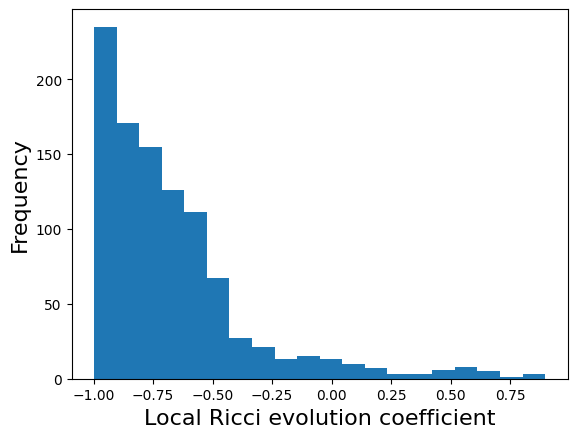

In [14]:
# Load dataset
X_train_MNIST_17,y_train_MNIST_17, X_test_MNIST_17, y_test_MNIST_17 = DatasetFactory.load_MNIST(digits=(1,7), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_MNIST_17,
    y_train=y_train_MNIST_17,
    X_test=X_test_MNIST_17,
    y_test=y_test_MNIST_17
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_MNIST_17, 50
).local_ricci_coefficient(curv='Ollivier-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.1.2 MNIST 6 vs. 9

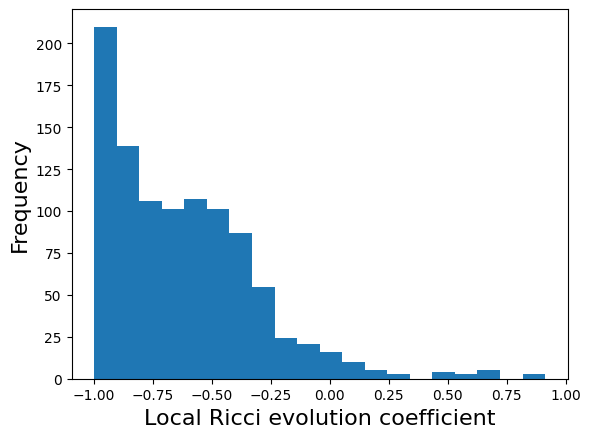

In [16]:
# Load dataset
X_train_MNIST_69,y_train_MNIST_69, X_test_MNIST_69, y_test_MNIST_69 = DatasetFactory.load_MNIST(digits=(6,9), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_MNIST_69,
    y_train=y_train_MNIST_69,
    X_test=X_test_MNIST_69,
    y_test=y_test_MNIST_69
)

# Compute local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_MNIST_69, 50
).local_ricci_coefficient(curv='Ollivier-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.1.3 Fashion-MNIST Shoes

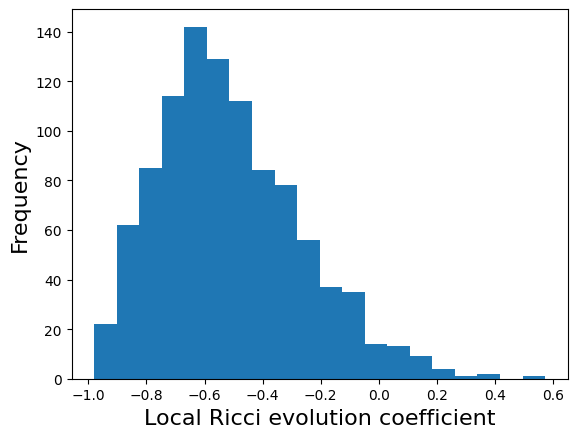

In [ ]:
# Load dataset
X_train_fMNIST_shoes,y_train_fMNIST_shoes, X_test_fMNIST_shoes, y_test_fMNIST_shoes = DatasetFactory.load_fMNIST(classes=(5,7), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_fMNIST_shoes,
    y_train=y_train_fMNIST_shoes,
    X_test=X_test_fMNIST_shoes,
    y_test=y_test_fMNIST_shoes
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_fMNIST_shoes, 50
).local_ricci_coefficient(curv='Ollivier-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.1.4 Fashion-MNIST Apperal

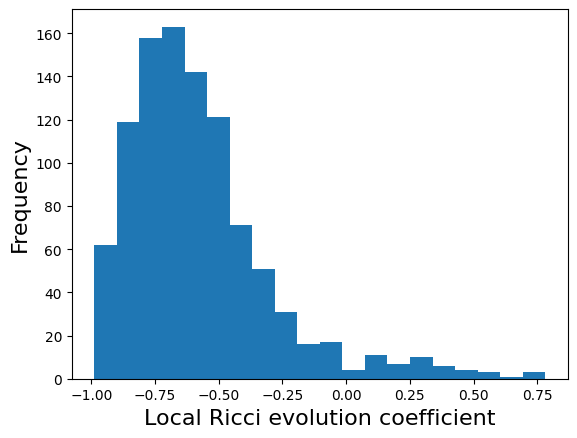

In [47]:
# Load dataset
X_train_fMNIST_apperal,y_train_fMNIST_apperal, X_test_fMNIST_apperal, y_test_fMNIST_apperal = DatasetFactory.load_fMNIST((3,6), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_fMNIST_apperal,
    y_train=y_train_fMNIST_apperal,
    X_test=X_test_fMNIST_apperal,
    y_test=y_test_fMNIST_apperal
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_fMNIST_apperal, 50
).local_ricci_coefficient(curv='Ollivier-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.1.5 CIFAR Car vs. Plane

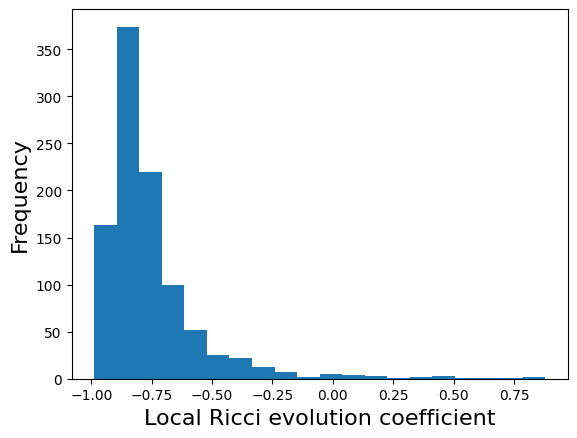

In [4]:
# Load dataset
X_train_CIFAR, y_train_CIFAR, X_test_CIFAR, y_test_CIFAR = DatasetFactory.load_CIFAR((0,1), device=device)

# Train model
model = DNN(input_dimension=3*32*32, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_CIFAR,
    y_train=y_train_CIFAR,
    X_test=X_test_CIFAR,
    y_test=y_test_CIFAR
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_CIFAR, 50
).local_ricci_coefficient(curv='Ollivier-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

## 3.2 Forman-Ricci curvature

### 3.2.1 MNIST 1 vs. 7

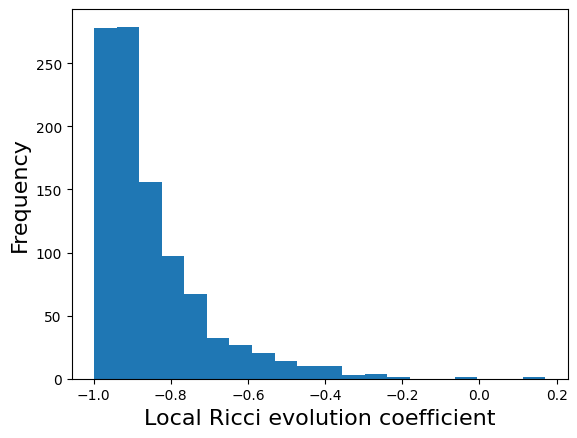

In [38]:
# Load dataset
X_train_MNIST_17,y_train_MNIST_17, X_test_MNIST_17, y_test_MNIST_17 = DatasetFactory.load_MNIST(digits=(1,7), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_MNIST_17,
    y_train=y_train_MNIST_17,
    X_test=X_test_MNIST_17,
    y_test=y_test_MNIST_17
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_MNIST_17, 50
).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.2.2 MNIST 6 vs. 9

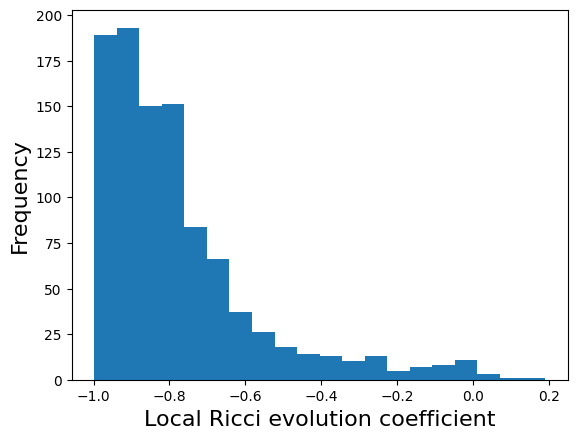

In [39]:
# Load dataset
X_train_MNIST_69,y_train_MNIST_69, X_test_MNIST_69, y_test_MNIST_69 = DatasetFactory.load_MNIST(digits=(6,9), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_MNIST_69,
    y_train=y_train_MNIST_69,
    X_test=X_test_MNIST_69,
    y_test=y_test_MNIST_69
)

# Compute local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_MNIST_69, 50
).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.2.3 Fashion-MNIST Shoes

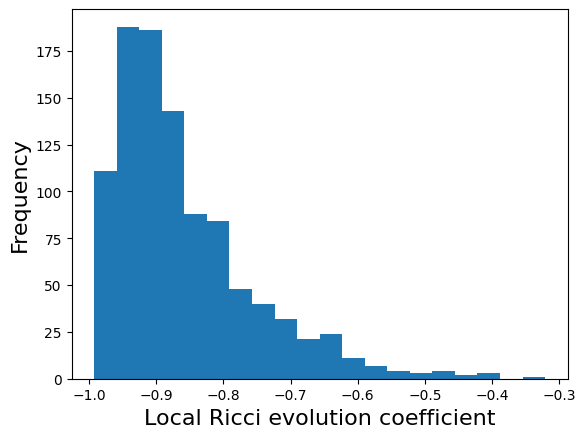

In [40]:
# Load dataset
X_train_fMNIST_shoes,y_train_fMNIST_shoes, X_test_fMNIST_shoes, y_test_fMNIST_shoes = DatasetFactory.load_fMNIST((5,7), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_fMNIST_shoes,
    y_train=y_train_fMNIST_shoes,
    X_test=X_test_fMNIST_shoes,
    y_test=y_test_fMNIST_shoes
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_fMNIST_shoes, 50
).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.2.4 Fashion-MNIST Apperal

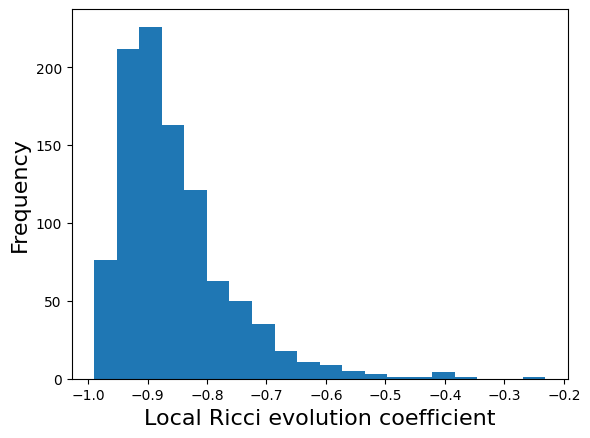

In [42]:
# Load dataset
X_train_fMNIST_apperal,y_train_fMNIST_apperal, X_test_fMNIST_apperal, y_test_fMNIST_apperal = DatasetFactory.load_fMNIST((3,6), device=device)

# Train model
model = DNN(input_dimension=784, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_fMNIST_apperal,
    y_train=y_train_fMNIST_apperal,
    X_test=X_test_fMNIST_apperal,
    y_test=y_test_fMNIST_apperal
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_fMNIST_apperal, 50
).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()

### 3.2.5 CIFAR Car vs. Plane

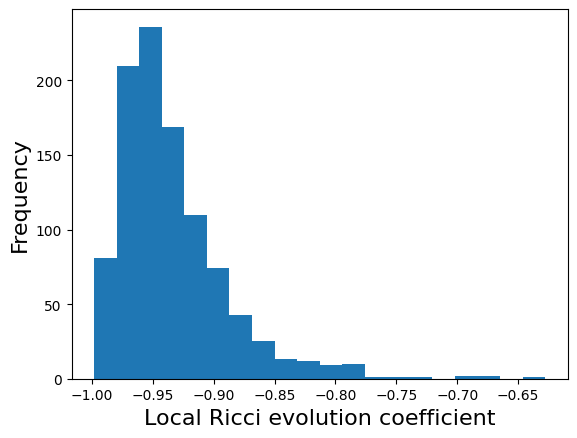

In [5]:
# Load dataset
X_train_CIFAR, y_train_CIFAR, X_test_CIFAR, y_test_CIFAR = DatasetFactory.load_CIFAR((0,1), device=device)

# Train model
model = DNN(input_dimension=3*32*32, hidden_units=50, depth=15, vision_model=True).to(device=device)
train_model(
    threshold_accuracy=99,
    model=model,
    X_train=X_train_CIFAR,
    y_train=y_train_CIFAR,
    X_test=X_test_CIFAR,
    y_test=y_test_CIFAR
)

# Calculate local Ricci evolution coefficients
local_ricci = Ricci_Coefficients(
    model, X_test_CIFAR, 50
).local_ricci_coefficient(curv='Augmented-Forman-Ricci')

# Plot histogram
_ , _ , _ = plt.hist(local_ricci,bins=20)
plt.ylabel("Frequency", fontsize=16)
plt.xlabel("Local Ricci evolution coefficient", fontsize=16)
plt.show()